In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from pysal.lib import weights
from splot.libpysal import plot_spatial_weights
import seaborn as sns
import esda
from splot.esda import (
    moran_scatterplot, lisa_cluster, plot_local_autocorrelation, plot_moran
)
from matplotlib import rc
rc('text', usetex=True) 

In [2]:
forest_data = gpd.read_file("Data_OSM/gis_osm_landuse_a_free_1.shp")
natural = gpd.read_file("Data_OSM/gis_osm_natural_free_1.shp")
places = gpd.read_file("Data_OSM/gis_osm_places_a_free_1.shp")
water = gpd.read_file("Data_OSM/gis_osm_water_a_free_1.shp")
waterways = gpd.read_file("Data_OSM/gis_osm_waterways_free_1.shp")

In [3]:
forest_data.head(2)

,osm_id,code,fclass,name,geometry
0,3098756,7202,park,Ørstedsparken,"POLYGON ((12.56406 55.68003, 12.56414 55.68013..."
1,3098803,7202,park,Botanisk Have,"POLYGON ((12.57037 55.68551, 12.57050 55.68566..."


#### Forest spatial autocorrelation

In [4]:
forests = forest_data[forest_data['fclass'] == 'forest']

In [5]:
administrative_areas = gpd.read_file('administrative_regions/au_inspire.gpkg')
administrative_areas.head(2)

,nationalcode,nationallevel,inspireid,nationallevelname,beginlifespanversion,endlifespanversion,country,name_gn_language,name_gn_nativeness,name_gn_namestatus,name_gn_sourceofname,name_gn_pronunciation,name_gn_spell_spellofna_text,name_gn_spell_spellofna_script,residenceofauthority,upperlevelunit,boundary,geometry
0,0187,3rdOrder,389120,Kommune,2023-03-20 15:40:28+00:00,NaT,DK,dan,endonym,official,None,None,Vallensbæk,Latn,None,389099,None,"POLYGON ((711858.740 6172750.380, 711833.580 6..."
1,0147,3rdOrder,389104,Kommune,2024-01-16 12:52:12+00:00,NaT,DK,dan,endonym,official,None,None,Frederiksberg,Latn,None,389099,None,"POLYGON ((722290.770 6177984.800, 722299.140 6..."


In [6]:
set(administrative_areas['nationallevelname'])

{'Country', 'Kommune', 'Region'}

In [7]:
# We want to compute the area of each kommune and the forestation percentage
kommuner = administrative_areas[administrative_areas['nationallevelname'] == 'Kommune']
kommuner['area_km2'] = kommuner.area / (10**6)
forests = forests.to_crs(kommuner.crs)


/Users/kas/Documents/GeospatialCourseProject/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [9]:
#Might want to do the other type of join
kommuner_with_forests = gpd.sjoin(forests,kommuner, how = 'left', op = 'intersects')

/Users/kas/Documents/GeospatialCourseProject/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [10]:
kommuner_with_forests['forest_area_km2'] = kommuner_with_forests.area / 10**6#.groupby('nationalcode')[.area

In [11]:
kommuner_with_forest_area = pd.merge(kommuner, kommuner_with_forests.groupby('nationalcode')['forest_area_km2'].sum(), on= 'nationalcode')

In [12]:
kommuner_with_forest_area['percentage_forest_area'] = (kommuner_with_forest_area['forest_area_km2'] / kommuner_with_forest_area['area_km2'])*100

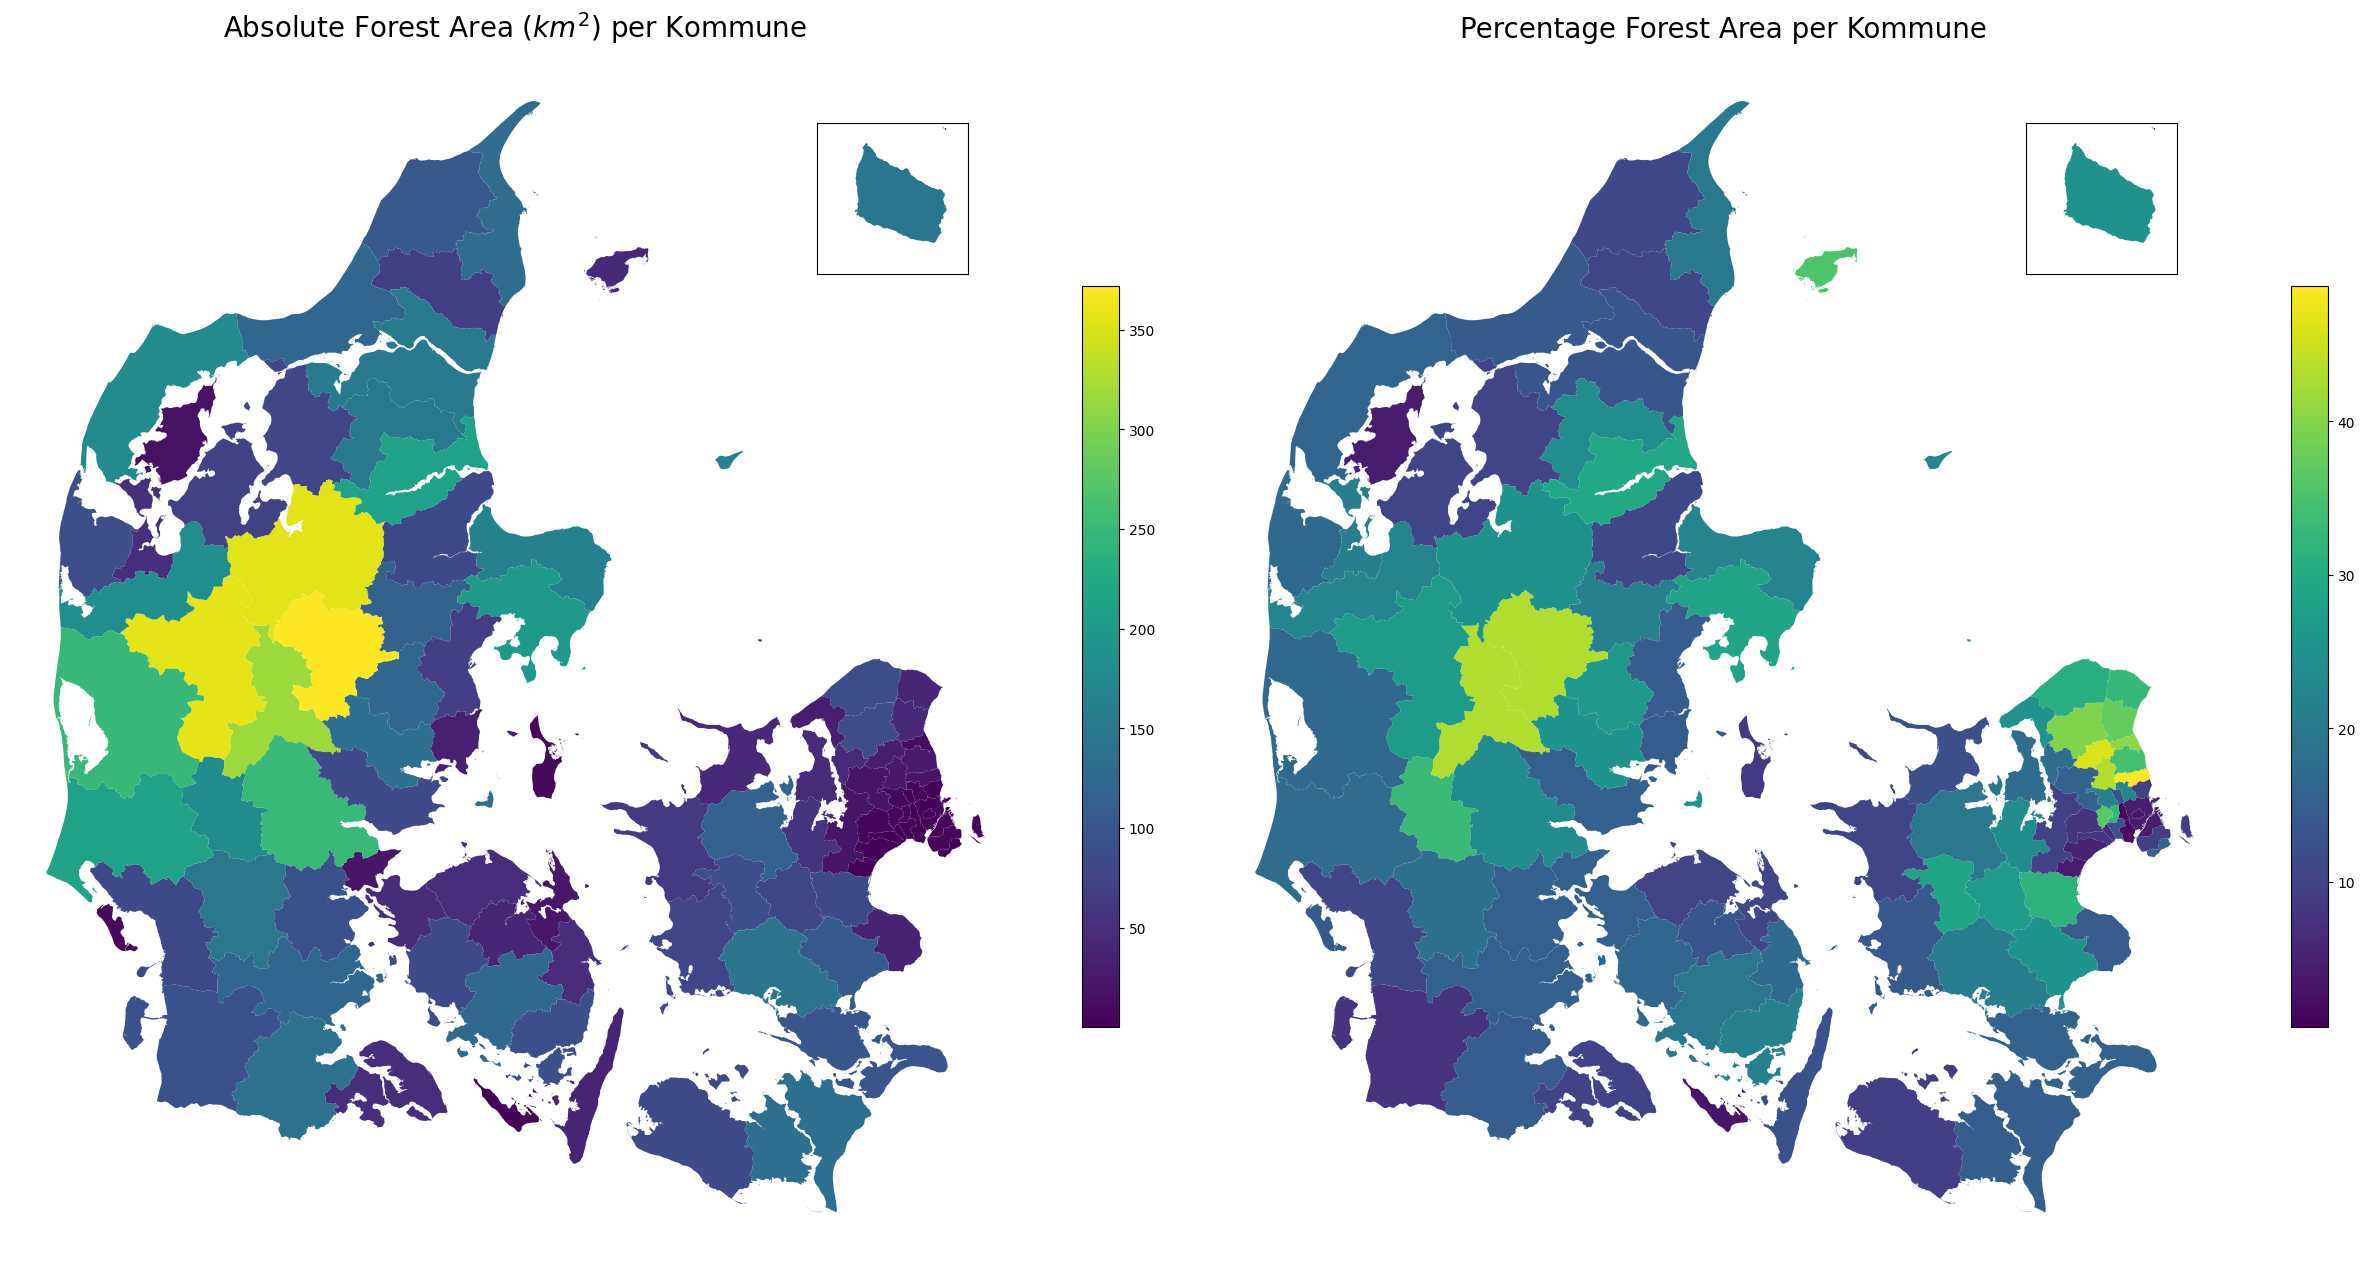

In [13]:
# Side by side
fig, ax = plt.subplots(1,2,figsize=(25, 25))
ax2 = ax[0].inset_axes([0.8, 0.8, 0.15, 0.15])
ax3 = ax[1].inset_axes([0.8, 0.8, 0.15, 0.15])
kommuner_with_forest_area.plot(
    column="forest_area_km2", 
    categorical=False, 
    legend=True,
    ax = ax[0],
    legend_kwds={'shrink': 0.3},
    #cmap='tab20b' # You can specificy your own colormap - but choose one that matches the type of variable (i.e. categorical/qualitative, sequential, diverging)
);
kommuner_with_forest_area.plot(
    column="percentage_forest_area", 
    categorical=False, 
    legend=True,
    ax = ax[1],
    legend_kwds={'shrink': 0.3},
    #cmap='tab20b' # You can specificy your own colormap - but choose one that matches the type of variable (i.e. categorical/qualitative, sequential, diverging)
);
#ax[0].axis('off')
ax[0].set_xlim(430000,750000)
ax[1].set_xlim(430000,750000)
kommuner_with_forest_area.plot(
    column="forest_area_km2", 
    categorical=False, 
    #legend=True,
    ax = ax2,
    #legend_kwds={'shrink': 0.3},
    #cmap='tab20b' # You can specificy your own colormap - but choose one that matches the type of variable (i.e. categorical/qualitative, sequential, diverging)
);
kommuner_with_forest_area.plot(
    column="percentage_forest_area", 
    categorical=False, 
    #legend=True,
    ax = ax3,
    #legend_kwds={'shrink': 0.3},
    #cmap='tab20b' # You can specificy your own colormap - but choose one that matches the type of variable (i.e. categorical/qualitative, sequential, diverging)
);


ax2.set_xlim([850000,900000])
ax2.set_ylim([6100000,6150000])
ax3.set_xlim([850000,900000])
ax3.set_ylim([6100000,6150000])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('Absolute Forest Area ($km^2$) per Kommune', fontsize = 20)
ax[1].set_title('Percentage Forest Area per Kommune', fontsize = 20)


plt.tight_layout()

### Global Spatial Autocorrelation

In [14]:
kommuner_with_forest_area.head(3)

,nationalcode,nationallevel,inspireid,nationallevelname,beginlifespanversion,endlifespanversion,country,name_gn_language,name_gn_nativeness,name_gn_namestatus,...,name_gn_pronunciation,name_gn_spell_spellofna_text,name_gn_spell_spellofna_script,residenceofauthority,upperlevelunit,boundary,geometry,area_km2,forest_area_km2,percentage_forest_area
0,0187,3rdOrder,389120,Kommune,2023-03-20 15:40:28+00:00,NaT,DK,dan,endonym,official,...,None,Vallensbæk,Latn,None,389099,None,"POLYGON ((711858.740 6172750.380, 711833.580 6...",9.494221,0.623894,6.571297
1,0147,3rdOrder,389104,Kommune,2024-01-16 12:52:12+00:00,NaT,DK,dan,endonym,official,...,None,Frederiksberg,Latn,None,389099,None,"POLYGON ((722290.770 6177984.800, 722299.140 6...",8.708695,0.309490,3.553810
2,0175,3rdOrder,389116,Kommune,2024-01-23 12:30:07+00:00,NaT,DK,dan,endonym,official,...,None,Rødovre,Latn,None,389099,None,"POLYGON ((716853.610 6179758.870, 716848.340 6...",12.170334,0.218383,1.794388


In [15]:
kommuner_with_forest_area = kommuner_with_forest_area.set_index("nationalcode", drop=False)

In [16]:
w = weights.Queen.from_dataframe(kommuner_with_forest_area, idVariable="nationalcode")

/var/folders/yg/c4d74b317nx312490v98___w0000gn/T/ipykernel_31553/3793492313.py:1: FutureWarning: `idVariable` is deprecated and will be removed in future. Use `ids` instead.
  w = weights.Queen.from_dataframe(kommuner_with_forest_area, idVariable="nationalcode")
/Users/kas/Documents/GeospatialCourseProject/.venv/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
 There are 8 islands with ids: 0411, 0563, 0492, 0741, 0482, 0773, 0825, 0400.
  W.__init__(self, neighbors, ids=ids, **kw)


In [22]:
w['0187']

{'0153': 1.0, '0165': 1.0, '0169': 1.0, '0183': 1.0}

In [17]:
kommuner_with_forest_area_weight = kommuner_with_forest_area
kommuner_with_forest_area_weight = kommuner_with_forest_area_weight.drop(w.islands)
w = weights.Queen.from_dataframe(kommuner_with_forest_area_weight, idVariable="nationalcode")

/var/folders/yg/c4d74b317nx312490v98___w0000gn/T/ipykernel_31553/3047128690.py:3: FutureWarning: `idVariable` is deprecated and will be removed in future. Use `ids` instead.
  w = weights.Queen.from_dataframe(kommuner_with_forest_area_weight, idVariable="nationalcode")
/Users/kas/Documents/GeospatialCourseProject/.venv/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


In [18]:
w.transform = 'R'

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

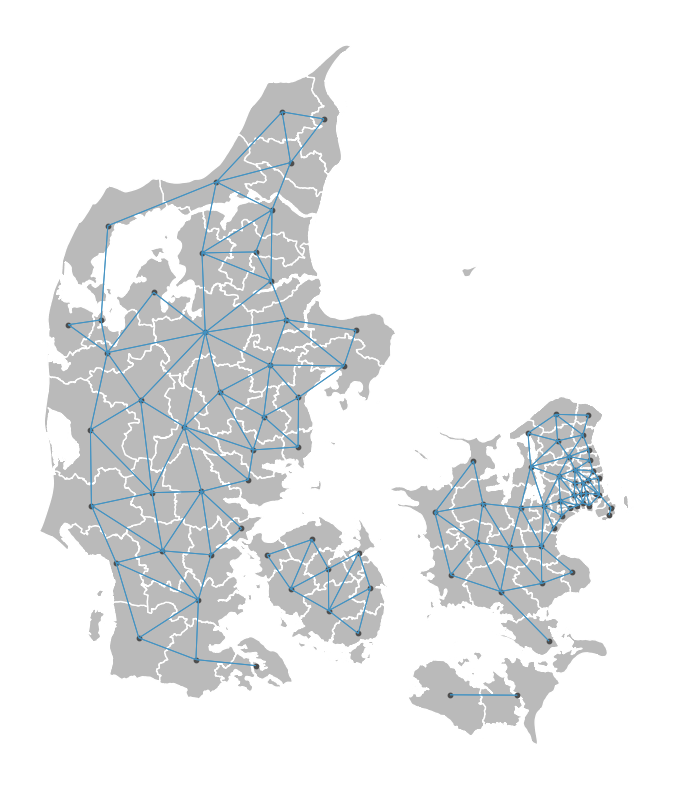

In [19]:
plot_spatial_weights(w,kommuner_with_forest_area_weight, indexed_on="nationalcode")

In [20]:
kommuner_with_forest_area_weight['w_percentage_forest_area'] = weights.lag_spatial(w, kommuner_with_forest_area_weight['percentage_forest_area'])

In [21]:
kommuner_with_forest_area_weight['percentage_forest_area_std'] = (
    kommuner_with_forest_area_weight['percentage_forest_area'] - kommuner_with_forest_area_weight['percentage_forest_area'].mean()
) / kommuner_with_forest_area_weight['percentage_forest_area'].std()

In [22]:
kommuner_with_forest_area_weight['w_percentage_forest_area_std'] = weights.lag_spatial(w, kommuner_with_forest_area_weight['percentage_forest_area_std'])

In [23]:
regions = administrative_areas[administrative_areas['nationallevelname'] =='Region']
kommuner_with_forest_area_weight_regions = pd.merge(kommuner_with_forest_area_weight, regions, how='left', left_on = 'upperlevelunit', right_on = 'inspireid')

<Axes: title={'center': 'Moran Plot of Global Spatial Correlation - Forestation Percentage per Kommune'}, xlabel='percentage_forest_area_std', ylabel='w_percentage_forest_area_std'>

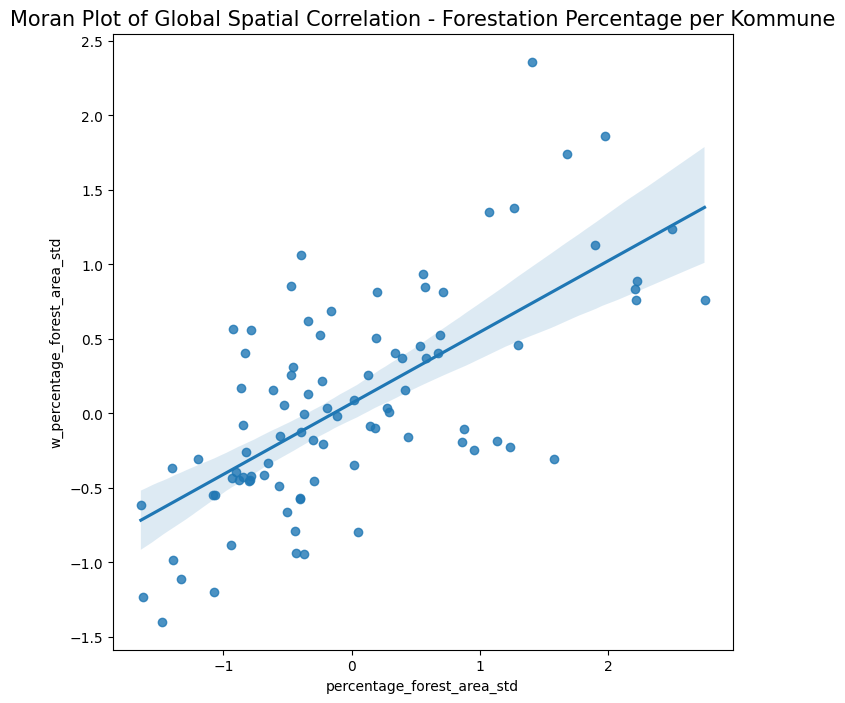

In [24]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(8, 8))
ax.set_title("Moran Plot of Global Spatial Correlation - Forestation Percentage per Kommune", fontsize = 15)
# Plot values
#groups = kommuner_with_forest_area_weight_regions.groupby('name_gn_spell_spellofna_text_y')[['percentage_forest_area_std', 'w_percentage_forest_area_std']]
#legend = []
#for name, group in groups:
#    legend.append(name)
sns.regplot(x='percentage_forest_area_std', y='w_percentage_forest_area_std', data = kommuner_with_forest_area_weight) #data=kommuner_with_forest_area_weight, ci=None, label = 'name_gn_spell_spellofna_text')
#g = sns.lmplot(data=kommuner_with_forest_area_weight_regions, x="percentage_forest_area", y="w_percentage_forest_area", ax)
# Add vertical and horizontal line
#plt.axvline(0, c='k', alpha=0.5)
#plt.axhline(0, c='k', alpha=0.5)
#ax.legend(legend)
# Display
#plt.show()

In [25]:
mi = esda.Moran(kommuner_with_forest_area_weight['percentage_forest_area'], w)

In [27]:
mi.I

0.47776792780252214

In [28]:
mi.p_sim

0.001

Text(0, 0.5, 'w_percentage_forest_area_std')

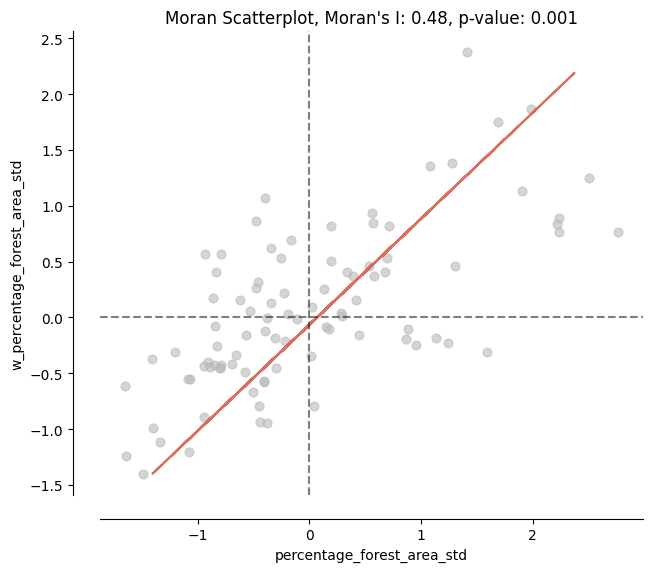

In [29]:
fig,ax = plt.subplots(1,1,figsize = (7,7))
moran_scatterplot(mi,ax = ax)
ax.set_title("Moran Scatterplot, Moran's I: 0.48, p-value: 0.001")
ax.set_xlabel('percentage_forest_area_std')
ax.set_ylabel('w_percentage_forest_area_std')

### Local Spatial Autocorrelation

In [30]:
lisa = esda.Moran_Local(kommuner_with_forest_area_weight['percentage_forest_area'], w)

In [31]:
# Break observations into significant or not
kommuner_with_forest_area_weight['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
kommuner_with_forest_area_weight['quadrant'] = lisa.q

Text(0.5, 1.0, 'Lisa Plot at 0.05 significance')

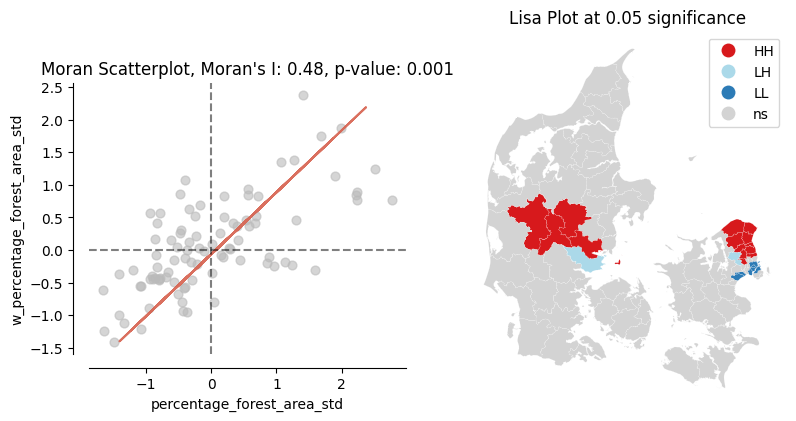

In [32]:
fig,ax = plt.subplots(1,2,figsize = (9,9))
moran_scatterplot(mi,ax = ax[0])
ax[0].set_title("Moran Scatterplot, Moran's I: 0.48, p-value: 0.001")
ax[0].set_xlabel('percentage_forest_area_std')
ax[0].set_ylabel('w_percentage_forest_area_std')
lisa_cluster(lisa, kommuner_with_forest_area_weight, p=0.05, ax=ax[1])
ax[1].set_title("Lisa Plot at 0.05 significance")

### Proposed new areas 

In [34]:
proposed_new_areas = gpd.read_file("raw_data/temporary_datasets/new_forest.shp")

In [35]:
# We want to compute the area of each kommune and the forestation percentage
kommuner = administrative_areas[administrative_areas['nationallevelname'] == 'Kommune']
kommuner['area_km2'] = kommuner.area / (10**6)
kommuner.shape


/Users/kas/Documents/GeospatialCourseProject/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


(99, 19)

In [36]:
new_areas_with_kommuner = pd.merge(kommuner[['area_km2','name_gn_spell_spellofna_text']],proposed_new_areas, how = 'inner', left_on = 'name_gn_spell_spellofna_text', right_on = 'region_nam')

In [37]:
forest_area_kommune = new_areas_with_kommuner.groupby('name_gn_spell_spellofna_text')['Area_km2'].sum()
new_dict = {'kommuner':forest_area_kommune.index, 'forest_area':list(forest_area_kommune)}
new_forest_area_kommuner_df = pd.DataFrame.from_dict(new_dict)


In [38]:
new_forest_kommuner_area_poly_df = pd.merge(kommuner[['name_gn_spell_spellofna_text','area_km2', 'geometry']], new_forest_area_kommuner_df, left_on='name_gn_spell_spellofna_text', right_on='kommuner')

In [39]:
new_forest_kommuner_area_poly_df ['percentage_area'] = (new_forest_kommuner_area_poly_df ['forest_area'] / new_forest_kommuner_area_poly_df ['area_km2']) *100

In [41]:
new_forest_kommuner_area_poly_df  = new_forest_kommuner_area_poly_df.set_index("name_gn_spell_spellofna_text", drop=False)

In [42]:
w = weights.Queen.from_dataframe(new_forest_kommuner_area_poly_df , idVariable="name_gn_spell_spellofna_text")
new_forest_kommuner_area_poly_df  = new_forest_kommuner_area_poly_df .drop(w.islands)
w = weights.Queen.from_dataframe(new_forest_kommuner_area_poly_df , idVariable="name_gn_spell_spellofna_text")

/var/folders/yg/c4d74b317nx312490v98___w0000gn/T/ipykernel_31553/561521424.py:1: FutureWarning: `idVariable` is deprecated and will be removed in future. Use `ids` instead.
  w = weights.Queen.from_dataframe(new_forest_kommuner_area_poly_df , idVariable="name_gn_spell_spellofna_text")
/Users/kas/Documents/GeospatialCourseProject/.venv/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
 There are 8 islands with ids: Christiansø, Fanø, Ærø, Samsø, Langeland, Morsø, Læsø, Bornholm.
  W.__init__(self, neighbors, ids=ids, **kw)
/var/folders/yg/c4d74b317nx312490v98___w0000gn/T/ipykernel_31553/561521424.py:3: FutureWarning: `idVariable` is deprecated and will be removed in future. Use `ids` instead.
  w = weights.Queen.from_dataframe(new_forest_kommuner_area_poly_df , idVariable="name_gn_spell_spellofna_text")
/Users/kas/Documents/GeospatialCourseProject/.venv/lib/python3.12/site-pack

In [43]:
w.transform = 'R'

In [44]:
lisa = esda.Moran_Local(new_forest_kommuner_area_poly_df['percentage_area'], w)

In [45]:
# Break observations into significant or not
new_forest_kommuner_area_poly_df ['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
new_forest_kommuner_area_poly_df ['quadrant'] = lisa.q

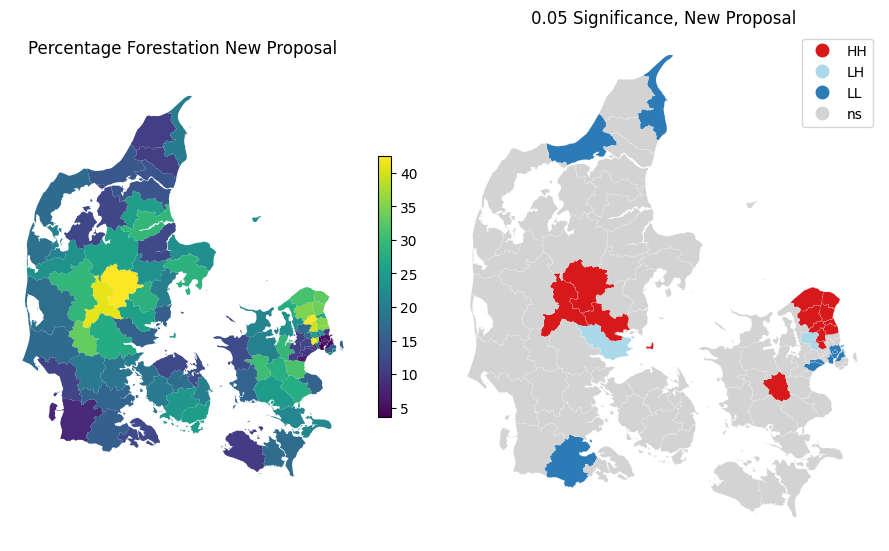

In [48]:
fig,ax = plt.subplots(1,2,figsize = (9,9))
# Percentage area
ax[0].set_xlim(430000,750000)
new_forest_kommuner_area_poly_df .plot(
    column="percentage_area", 
    categorical=False, 
    legend=True,
    ax = ax[0],
    legend_kwds = {'shrink':0.3}
    #cmap='tab20b' # You can specificy your own colormap - but choose one that matches the type of variable (i.e. categorical/qualitative, sequential, diverging)
);
ax2 = ax[0].inset_axes([0.8, 0.8, 0.15, 0.15])
new_forest_kommuner_area_poly_df .plot(
    column="percentage_area", 
    categorical=False, 
    #legend=True,
    ax = ax2,
    #legend_kwds={'shrink': 0.3},
    #cmap='tab20b' # You can specificy your own colormap - but choose one that matches the type of variable (i.e. categorical/qualitative, sequential, diverging)
);
#mi = esda.Moran(new_forest_kommuner_area_poly_df ['percentage_area'], w)
#moran_scatterplot(mi,ax = ax[2])
#ax[2].set_title("Moran's I: 0.41, p-value: 0.001")
#ax[2].set_xlabel('percentage_forest_area_std')
#ax[2].set_ylabel('w_percentage_forest_area_std')
ax2.set_xlim([850000,900000])
ax2.set_ylim([6100000,6150000])
#moran_scatterplot(mi,ax = ax[0])
#ax[0].set_title("Moran Scatterplot, Moran's I: 0.48, p-value: 0.001")
#ax[0].set_xlabel('percentage_forest_area_std')
#ax[0].set_ylabel('w_percentage_forest_area_std')
lisa_cluster(lisa, new_forest_kommuner_area_poly_df , p=0.05, ax=ax[1])
ax[1].set_title("0.05 Significance, New Proposal")
ax[0].axis('off')
ax2.axis('off')
ax[0].set_title('Percentage Forestation New Proposal')
plt.tight_layout()

Text(0, 0.5, 'w_percentage_forest_area_std')

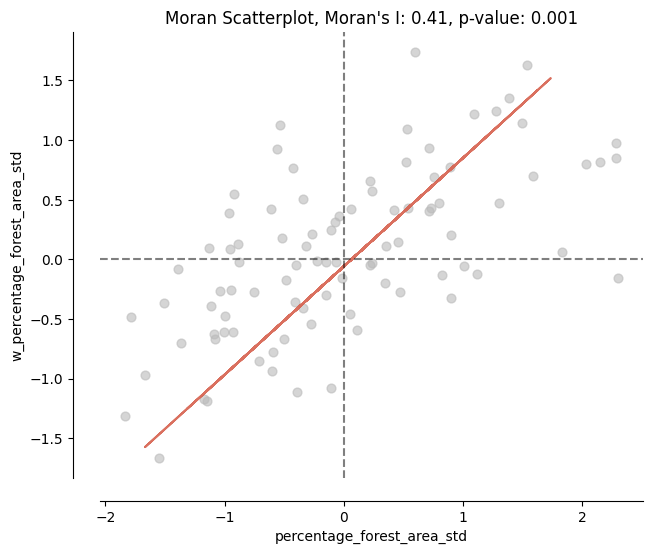

In [47]:
fig,ax = plt.subplots(1,1,figsize = (7,7))
mi = esda.Moran(new_forest_kommuner_area_poly_df ['percentage_area'], w)
moran_scatterplot(mi,ax = ax)
ax.set_title("Moran Scatterplot, Moran's I: 0.41, p-value: 0.001")
ax.set_xlabel('percentage_forest_area_std')
ax.set_ylabel('w_percentage_forest_area_std')

In [88]:
mi.p_sim

0.001

In [89]:
mi.I

0.41202201808071925